0 files missing from root.txt in /Users/schko/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /Users/schko/mne_data/MNE-fsaverage-data/fsaverage
Reading labels from parcellation...
   read 82 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.PALS_B12_Brodmann.annot
   read 46 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.PALS_B12_Brodmann.annot
reading participant-level motor data
found cleaned epochs
Adding metadata with 5 columns
509 matching events found
No baseline correction applied
removing ovlerlapping motor trials, starting epoch count 6291
post removal epoch count 6218
Replacing existing metadata with 75 columns
Applying baseline correction (mode: mean)
\begin{tabular}{rrrr}
\toprule
 sub &  w\_opacities &  const &  p\_opacities \\
\midrule
  20 &        -0.63 &   0.80 &         0.00 \\
  14 &        -0.15 &   0.24 &         0.00 \\
  12 &        -1.06 &   0.96 &         0.00 \\
  22 &        -1.18 &   1.33 &         

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 7809 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 2303.5 ms
Checking surface interior status for 10242 points...
    Found  2241/10242 points inside  an interior sphere of radius   47.7 mm
    Found     0/10242 points outside an exterior sphere of radius   98.3 mm
    Found     0/ 8001 points outside using surface Qhull


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


    Found     0/ 8001 points outside using solid angles
    Total 10242/10242 points inside the surface
Interior check completed in 2337.4 ms

Setting up for EEG...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s finished


Computing EEG at 20484 source locations (free orientations)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



Finished.
Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.0s finished


    Using tolerance 6.1e-07 (2.2e-16 eps * 64 dim * 4.3e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    EEG regularization : 0.1
    EEG regularization : 0.1
    EEG regularization : 0.1
Number of samples used : 326269
log-likelihood on unseen data (descending order):
   shrunk: -706.964
   diagonal_fixed: -794.575
   empirical: -338786.930
selecting best estimator: shrunk
[done]
Computing rank from covariance with rank=None
    Using tolerance 2.4e-07 (2.2e-16 eps * 64 dim * 1.7e+07  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors


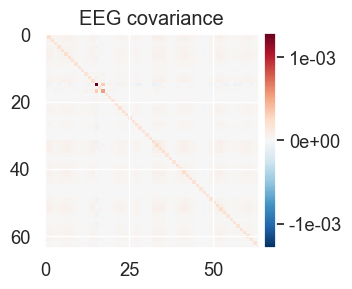

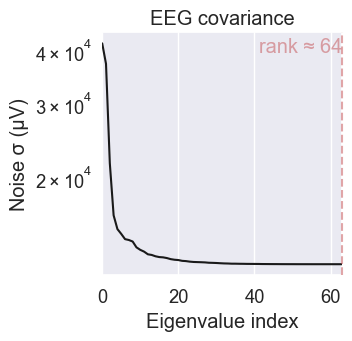

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 64 channels.
    64 out of 64 channels remain after picking
Selected 64 channels
Creating the depth weighting matrix...
    64 EEG channels
    limit = 20485/20484 = 2.329337
    scale = 108975 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank=None
    Using tolerance 2.2e-07 (2.2e-16 eps * 64 dim * 1.5e+07  max singular value)
    Estimated rank (eeg): 63
    EEG: rank 63 computed from 64 data channels with 1 projector
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD

In [16]:
%run 2-source.ipynb
# low_motor_sensor = motor_epochs["Steer_Wheel_Degree_Categorical == 'Low'"]
# high_motor_sensor = motor_epochs["Steer_Wheel_Degree_Categorical == 'High'"]

# Functional connectivity

In [2]:
from pathlib import Path

from mne import (make_forward_solution, setup_source_space,
                 setup_volume_source_space)
from mne.io import read_raw_fif
from mne.minimum_norm import apply_inverse_epochs, make_inverse_operator
from mne.viz import circular_layout
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

In [3]:
rel_labels, rel_mappings = get_relevant_labels_mappings(path_to_base_package) # for all regions use 'all'
for l in rel_labels:
    l.name = f"{rel_mappings[l.name]}-{l.hemi}"

Reading labels from parcellation...
   read 82 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.PALS_B12_Brodmann.annot
   read 46 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.PALS_B12_Brodmann.annot


In [4]:
def get_connectivity_plot(rel_stcs, output_dir, fmin, fmax, fig_title = 'Motor'):
    # Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
    labels_parc = mne.read_labels_from_annot(subject, parc='aparc',
                                            subjects_dir=subjects_dir)
    labels_parc = rel_labels
    # Average the source estimates within each label of the cortical parcellation
    # and each sub-structure contained in the source space.
    # When mode = 'mean_flip', this option is used only for the cortical labels.
    src = inverse_operator['src']
    label_ts = mne.extract_label_time_course(
        rel_stcs, labels_parc, src, mode='mean_flip', allow_empty=True,
        return_generator=True, verbose=False)

    # We compute the connectivity in the alpha band and plot it using a circular
    # graph layout
    fmin = fmin
    fmax = fmax
    sfreq = motor_epochs.info['sfreq']  # the sampling frequency
    con = spectral_connectivity_epochs(
        label_ts, method='pli', mode='multitaper', sfreq=sfreq, fmin=fmin,
        fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=5,verbose=False)

    # We create a list of Label containing also the sub structures
    labels_aseg = mne.get_volume_labels_from_src(src, subject, subjects_dir)
    labels = labels_parc + labels_aseg

    # read colors
    node_colors = [label.color for label in labels]

    # We reorder the labels based on their location in the left hemi
    label_names = [label.name for label in labels]
    lh_labels = [name for name in label_names if name.endswith('lh')]
    rh_labels = [name for name in label_names if name.endswith('rh')]

    # Get the y-location of the label
    label_ypos_lh = list()
    for name in lh_labels:
        idx = label_names.index(name)
        ypos = np.mean(labels[idx].pos[:, 1])
        label_ypos_lh.append(ypos)
    try:
        idx = label_names.index('Brain-Stem')
    except ValueError:
        pass
    else:
        ypos = np.mean(labels[idx].pos[:, 1])
        lh_labels.append('Brain-Stem')
        label_ypos_lh.append(ypos)


    # Reorder the labels based on their location
    lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

    # For the right hemi
    rh_labels = [label[:-2] + 'rh' for label in lh_labels
                if label != 'Brain-Stem' and label[:-2] + 'rh' in rh_labels]

    # Save the plot order
    node_order = lh_labels[::-1] + rh_labels

    node_angles = circular_layout(label_names, node_order, start_pos=90,
                                group_boundaries=[0, len(label_names) // 2])


    # Plot the graph using node colors from the FreeSurfer parcellation. We only
    # show the 300 strongest connections.
    conmat = con.get_data(output='dense')[:, :, 0]

    fig, ax = plt.subplots(figsize=(8, 8), facecolor='black',
                        subplot_kw=dict(polar=True))
    plot_connectivity_circle(conmat, label_names, n_lines=300, vmin = 0, vmax = .30,
                            node_angles=node_angles, node_colors=node_colors,
                            title=f"All-to-All Connectivity {fig_title} Epochs", ax=ax)
    fig.tight_layout()
    Path(f"{output_dir}/connectivity").mkdir(parents=True, exist_ok=True)
    fname_fig = f"{output_dir}/connectivity/{fig_title}_plot_mixed_connect.png"
    fig.savefig(fname_fig, facecolor=fig.get_facecolor())
    np.save(f"{output_dir}/connectivity/{fig_title}_conn",conmat)

## NOTE WE LIMIT TO 2000 EPOCHS FOR MEMORY USAGE


band (4.0, 8.0, 'Theta')
Reading labels from parcellation...
   read 35 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 325 connections
    using t=0.000s..1.250s for estimation (161 points)
    frequencies: 4.8Hz..8.0Hz (5 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..5
Extracting time courses for 26 labels (mode:

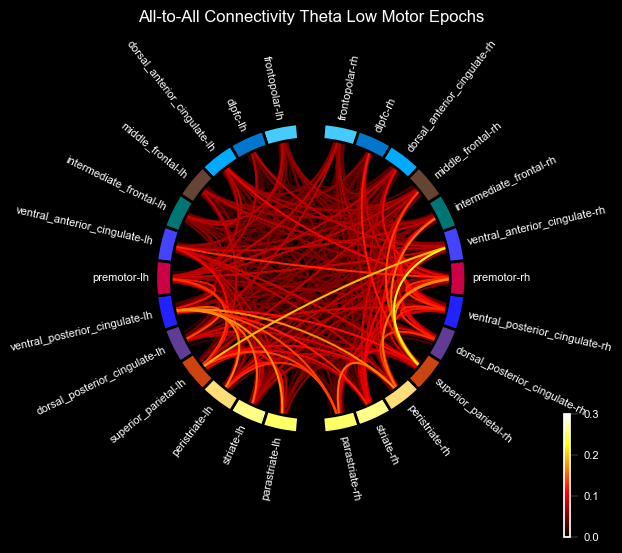

band (8.0, 15.0, 'Alpha')
Reading labels from parcellation...
   read 35 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 325 connections
    using t=0.000s..1.250s for estimation (161 points)
    frequencies: 8.7Hz..14.3Hz (8 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..5
Extracting time courses for 26 labels (mod

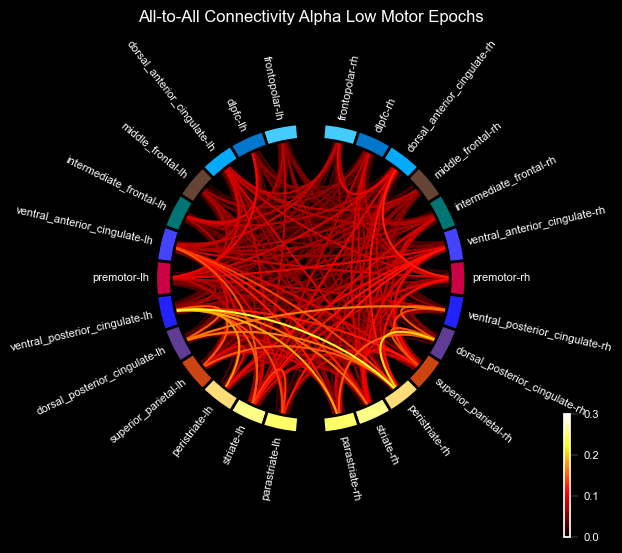

band (15.0, 32.0, 'Beta')
Reading labels from parcellation...
   read 35 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 325 connections
    using t=0.000s..1.250s for estimation (161 points)
    frequencies: 15.1Hz..31.8Hz (22 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..5
Extracting time courses for 26 labels (m

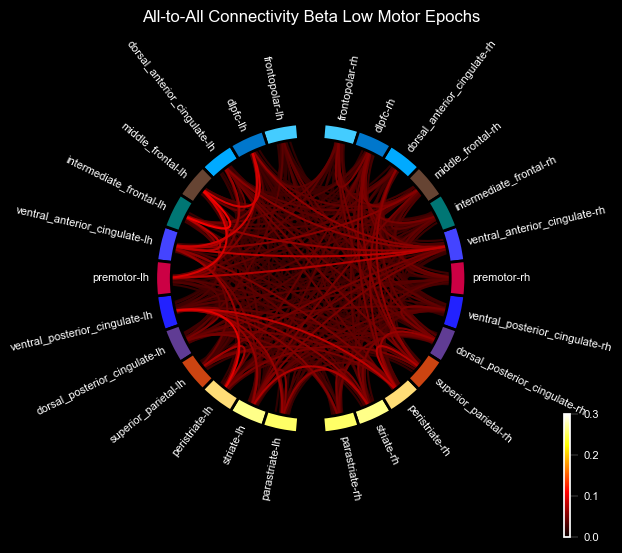

band (32.0, 55.0, 'Gamma')
Reading labels from parcellation...
   read 35 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /Users/schko/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot
Connectivity computation...
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
Extracting time courses for 26 labels (mode: mean_flip)
only using indices for lower-triangular matrix
    computing connectivity for 325 connections
    using t=0.000s..1.250s for estimation (161 points)
    frequencies: 32.6Hz..54.9Hz (29 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI
    computing connectivity for epochs 1..5
Extracting time courses for 26 labels (

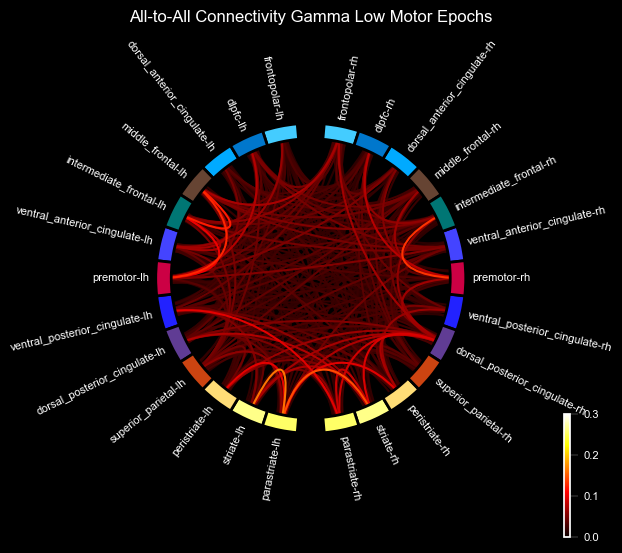

: 

: 

In [5]:
bands = [(4.,8.,'Theta'), (8.,15.,'Alpha'), (15.,32.,'Beta'), (32., 55., 'Gamma')]

cond = 'Low'
rel_stcs = mne.minimum_norm.apply_inverse_epochs(low_motor_sensor[np.round(np.linspace(0, len(low_motor_sensor)-1, 2000)).astype(int)], inverse_operator,
                                lambda2=1.0 / snr ** 2, verbose=False,
                                method="eLORETA", pick_ori="normal")
for band in bands:
    print('band', band)
    get_connectivity_plot(rel_stcs,output_dir,fmin = band[0], fmax = band[1], fig_title = f"{band[2]} {cond} Motor")


cond = 'High'
rel_stcs = mne.minimum_norm.apply_inverse_epochs(high_motor_sensor[np.round(np.linspace(0, len(high_motor_sensor)-1, 2000)).astype(int)], inverse_operator,
                                lambda2=1.0 / snr ** 2, verbose=False,
                                method="eLORETA", pick_ori="normal")
for band in bands:
    print('band', band)
    get_connectivity_plot(rel_stcs,output_dir,fmin = band[0], fmax = band[1], fig_title = f"{band[2]} {cond} Motor")


# Decoding source space data

In [4]:
from mne.decoding import (LinearModel, SlidingEstimator, cross_val_multiscore,
                          get_coef)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
interval = 4
stcs = mne.minimum_norm.apply_inverse_epochs(motor_epochs[::interval], inverse_operator,
                            lambda2=1.0 / snr ** 2, verbose=False,
                            method="eLORETA", pick_ori="normal")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


  0%|          | Fitting SlidingEstimator : 0/161 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.9s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.0min remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/161 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   21.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 11.1min remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/161 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.8s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.6min remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/161 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.4s finished
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 21.2min remaining:    0.0s


  0%|          | Fitting SlidingEstimator : 0/161 [00:00<?,       ?it/s]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 27.3min finished


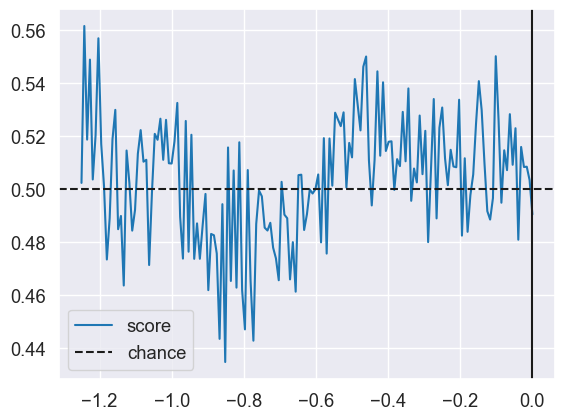

In [4]:
# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = motor_epochs[::interval].metadata.Steer_Wheel_Degree_Encoded # for sparse: motor_epochs[::7]

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LogisticRegression(C=1, solver='lbfgs')))
time_decod = SlidingEstimator(clf, scoring='roc_auc')

# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

In [6]:
# The fitting needs not be cross validated because the weights are based on
# the training sets
time_decod.fit(X, y)

# Retrieve patterns after inversing the z-score normalization step:
patterns = get_coef(time_decod, 'patterns_', inverse_transform=True)

stc = stcs[0]  # for convenience, lookup parameters from first stc
vertices = [stc.lh_vertno, np.array([], int)]  # empty array for right hemi
stc_feat = mne.SourceEstimate(np.abs(patterns), vertices=vertices,
                              tmin=stc.tmin, tstep=stc.tstep, subject='fsaverage')

brain = stc_feat.plot(views=['lat'], transparent=True, subject='fsaverage',time_unit='s')

  0%|          | Fitting SlidingEstimator : 0/161 [00:00<?,       ?it/s]

Using control points [2.17436670e-12 2.82231276e-12 1.23038247e-11]


### CSP

In [8]:
# Retrieve source space data into an array
print('starting')
X = np.array([stc.lh_data for stc in stcs])  # only keep left hemisphere
y = np.array(motor_epochs[::interval].metadata.Steer_Wheel_Degree_Encoded)
print('decoding')
csp = mne.decoding.CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(
    csp
)
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=1)
print('CSP: %0.1f%%' % (100 * scores.mean(),))

starting
decoding


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator Pipeline(steps=[('csp',
                 CSP({'component_order': 'mutual_info',
 'cov_est': 'concat',
 'cov_method_params': None,
 'log': None,
 'n_components': 3,
 'norm_trace': False,
 'rank': None,
 'reg': None,
 'transform_into': 'average_power'}))]) does not.

In [ ]:
X.shape, y.shape

((52, 10242, 161), (733,))

In [ ]:

# Retrieve source space data into an array
X = np.array([stc.lh_data for stc in stcs])
y = motor_epochs[::7].metadata.Abs_Steer_Wheel_Degree

# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LinearRegression()))
time_decod = SlidingEstimator(clf, scoring='neg_mean_squared_error')
# Run cross-validated decoding analyses:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=None)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(motor_epochs.times, -scores.mean(0), label='score')
ax.axhline(mean_squared_error(y,[np.mean(y)]*len(y)), color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()

ValueError: Found input variables with inconsistent numbers of samples: [52, 733]

In [ ]:
y = motor_epochs.metadata.Abs_Steer_Wheel_Degree

print(mean_squared_error(y,[np.mean(y)]*len(y),squared=False)), print(np.sqrt(0.025))

## Source permutation t-tests with clustering

In [ ]:
#low_motor.resample(50, npad='auto')
condition1 = mne.minimum_norm.apply_inverse(low_motor_sensor.average(), inverse_operator, lambda2, method)
#high_motor.resample(50, npad='auto')
condition2 = mne.minimum_norm.apply_inverse(high_motor_sensor.average(), inverse_operator, lambda2, method)

tmin = condition1.tmin
tstep = condition1.tstep * 1000  # convert to milliseconds

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 2697
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 1)
    Created the whitener using a noise covariance matrix with rank 63 (1 small eigenvalues omitted)
    Computing optimized source covariance (eLORETA)...
        Using independent orientation weights
        Fitting up to 20 iterations (this make take a while)...
        Converged on iteration 8 (6.8e-07 < 1e-06)
        Updating inverse with weighted eigen leads
[done]
Applying inverse operator to "0.32 × easy + 0.23 × hard + 0.45 × unknown"...
    Picked 64 channels from the data
    Computing inverse...
    Eigenleads already weighted ... 
    Computing residual...
    Explained  85.1% variance
    Combining the current components...
[done]
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 2429
    Created the regularized inverter


In [ ]:
from mne import spatial_src_adjacency
from mne.stats import spatio_temporal_cluster_test, summarize_clusters_stc
import scipy
src = mne.read_source_spaces(src_fname)
n_subjects1, n_subjects2 = 60, 60
n_vertices_fsave, n_times = condition1.data.shape
print('Simulating data for %d and %d subjects.' % (n_subjects1, n_subjects2))

#    Let's make sure our results replicate, so set the seed.
np.random.seed(0)
X1 = np.random.randn(n_vertices_fsave, n_times, n_subjects1)*10
X2 = np.random.randn(n_vertices_fsave, n_times, n_subjects2)*10
X1[:, :, :] += condition1.data[:, :, np.newaxis]
X2[:, :, :] += 3*condition2.data[:, :, np.newaxis]
#    We want to compare the overall activity levels for each subject
X1 = np.abs(X1)  # only magnitude
X2 = np.abs(X2)  # only magnitude
print('Computing adjacency.')
adjacency = spatial_src_adjacency(src)

#    Note that X needs to be a list of multi-dimensional array of shape
#    samples (subjects_k) × time × space, so we permute dimensions
X1 = np.transpose(X1, [2, 1, 0])
X2 = np.transpose(X2, [2, 1, 0])
X = [X1, X2]
# Now let's actually do the clustering. This can take a long time...
# Here we set the threshold quite high to reduce computation,
# and use a very low number of permutations for the same reason.
n_permutations = 50 # 50 to test, 1024 ideally
p_threshold = .05
f_threshold = scipy.stats.distributions.f.ppf(1. - p_threshold / 2.,
                                        n_subjects1 - 1, n_subjects2 - 1)
print('Clustering.')
F_obs, clusters, cluster_p_values, H0 = clu =\
    spatio_temporal_cluster_test(
        X, adjacency=adjacency, n_jobs=5, n_permutations=n_permutations,
        threshold=f_threshold, buffer_size=None)
#    Now select the clusters that are sig. at p < 0.05 (note that this value
#    is multiple-comparisons corrected).
good_cluster_inds = np.where(cluster_p_values < 0.05 )[0]

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
Simulating data for 60 and 60 subjects.
Computing adjacency.
-- number of adjacent vertices : 20484
Clustering.
stat_fun(H1): min=0.000000 max=25.034172
Running initial clustering …
Found 204174 clusters


  0%|          | Permuting : 0/49 [00:00<?,       ?it/s]

In [ ]:
print('Visualizing clusters.')

#    Now let's build a convenient representation of each cluster, where each
#    cluster becomes a "time point" in the SourceEstimate
fsave_vertices = [np.arange(10242), np.arange(10242)]
stc_all_cluster_vis = summarize_clusters_stc(clu, tstep=tstep,p_thresh=.05, tmin=-1,
                                             vertices=fsave_vertices,
                                             subject='fsaverage')

#    Let's actually plot the first "time point" in the SourceEstimate, which
#    shows all the clusters, weighted by duration

# blue blobs are for condition A != condition B
brain = stc_all_cluster_vis.plot('fsaverage', hemi='both',
                                 views='lateral', subjects_dir=subjects_dir,
                                 time_label='temporal extent (ms)',
                                 clim=dict(kind='value', lims=[0, 1, 40]))